# Бинарная классификация изображений (кошки/собаки) с использованиемпредобученной EfficientNet.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
import torchvision.transforms as T
from IPython.display import Image
from skimage import io
from torchvision.utils import make_grid
import shutil
import torchvision.models as models
from tqdm.notebook import tqdm
from PIL import Image
from google.colab import files

In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O cats_and_dogs_filtered.zip

--2025-08-29 23:32:44--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.70.207, 74.125.24.207, 172.253.118.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.70.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M  20.5MB/s    in 4.0s    

2025-08-29 23:32:48 (16.3 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [ ]:
! pip install torchinfo
from torchinfo import summary

In [ ]:
! pip install pytorch-ignite --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 343.2/343.2 kB 25.3 MB/s eta 0:00:00


In [ ]:
shutil.unpack_archive("/content/cats_and_dogs_filtered.zip",
                      "cats_and_dogs_filtered")

In [ ]:
train_path = '/content/cats_and_dogs_filtered/cats_and_dogs_filtered/train'
val_path = '/content/cats_and_dogs_filtered/cats_and_dogs_filtered/validation'

In [ ]:
transform = T.Compose([T.Resize([256, 256]), T.ToTensor()])

In [ ]:
train_dataset = datasets.ImageFolder(train_path, transform=transform)
val_dataset = datasets.ImageFolder(val_path, transform=transform)

In [ ]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size, shuffle=True)

torch.Size([32, 3, 256, 256])


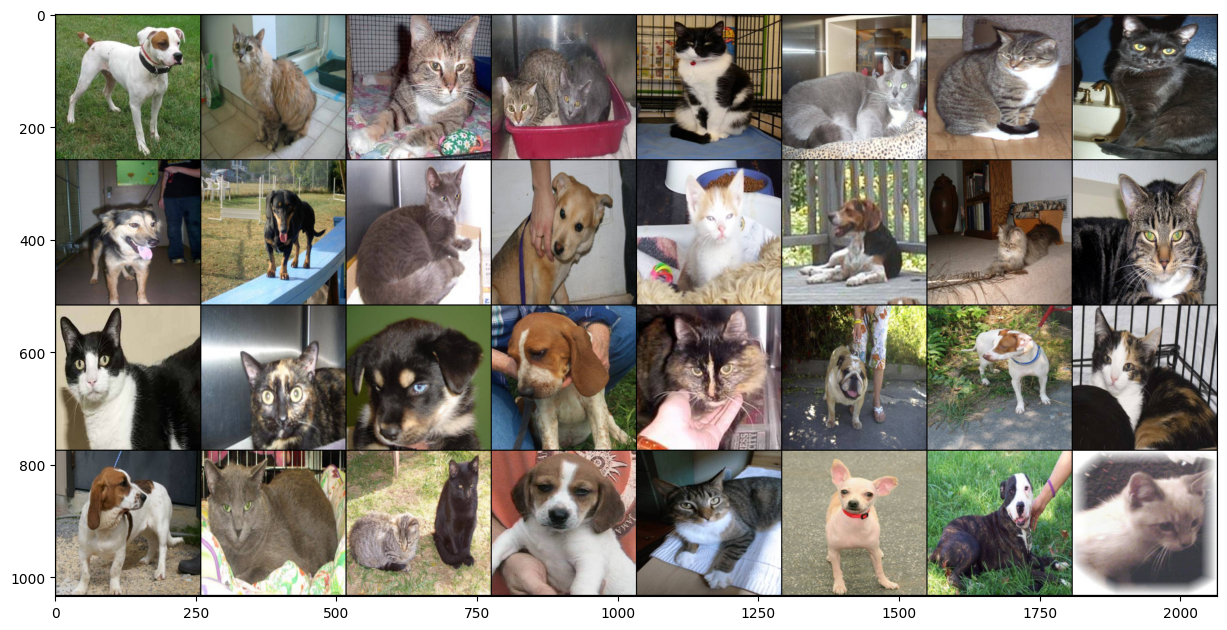

In [ ]:
def show_batch(data_loader):
    images, labels = next(iter(data_loader))
    fig, ax = plt.subplots(figsize=(15,15))
    ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0).clamp(0, 1))
    print(images.shape)

show_batch(train_loader)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
model = models.efficientnet_b0(weights='EfficientNet_B0_Weights.IMAGENET1K_V1')
model.to(device);

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 202MB/s]


In [ ]:
summary(model,input_size=(1,3,224,224))

Layer (type:depth-idx)                                  Output Shape              Param #
EfficientNet                                            [1, 1000]                 --
├─Sequential: 1-1                                       [1, 1280, 7, 7]           --
│    └─Conv2dNormActivation: 2-1                        [1, 32, 112, 112]         --
│    │    └─Conv2d: 3-1                                 [1, 32, 112, 112]         864
│    │    └─BatchNorm2d: 3-2                            [1, 32, 112, 112]         64
│    │    └─SiLU: 3-3                                   [1, 32, 112, 112]         --
│    └─Sequential: 2-2                                  [1, 16, 112, 112]         --
│    │    └─MBConv: 3-4                                 [1, 16, 112, 112]         1,448
│    └─Sequential: 2-3                                  [1, 24, 56, 56]           --
│    │    └─MBConv: 3-5                                 [1, 24, 56, 56]           6,004
│    │    └─MBConv: 3-6                              

In [ ]:
model.classifier[1] = nn.Linear(1280, 2)

In [ ]:
for param in model.parameters():
    param.requires_grad = False

for param in model.classifier[1].parameters():
    param.requires_grad = True


In [ ]:
summary(model,input_size=(1,3,224,224))

Layer (type:depth-idx)                                  Output Shape              Param #
EfficientNet                                            [1, 2]                    --
├─Sequential: 1-1                                       [1, 1280, 7, 7]           --
│    └─Conv2dNormActivation: 2-1                        [1, 32, 112, 112]         --
│    │    └─Conv2d: 3-1                                 [1, 32, 112, 112]         (864)
│    │    └─BatchNorm2d: 3-2                            [1, 32, 112, 112]         (64)
│    │    └─SiLU: 3-3                                   [1, 32, 112, 112]         --
│    └─Sequential: 2-2                                  [1, 16, 112, 112]         --
│    │    └─MBConv: 3-4                                 [1, 16, 112, 112]         (1,448)
│    └─Sequential: 2-3                                  [1, 24, 56, 56]           --
│    │    └─MBConv: 3-5                                 [1, 24, 56, 56]           (6,004)
│    │    └─MBConv: 3-6                      

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=3e-4)
criterion = nn.CrossEntropyLoss()

In [ ]:
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss, RunningAverage, ConfusionMatrix
from ignite.handlers import ModelCheckpoint, EarlyStopping
from ignite.contrib.handlers import ProgressBar, HandlersTimeProfiler
from ignite.handlers import Checkpoint, global_step_from_engine

In [ ]:
trainer = create_supervised_trainer(model, optimizer, criterion, device=device)

In [ ]:
metrics = { "loss" : Loss(criterion),
           "accuracy" : Accuracy(),
            "cm": ConfusionMatrix(num_classes=2)}

In [ ]:
train_evaluator = create_supervised_evaluator(model, metrics = metrics, device = device)
val_evaluator = create_supervised_evaluator(model, metrics = metrics, device = device)

In [ ]:
training_history = {'accuracy':[],'loss':[]}
val_history = {'accuracy':[],'loss':[]}
last_epoch = []

In [ ]:
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    train_evaluator.run(train_loader)
    metrics = train_evaluator.state.metrics
    accuracy = metrics['accuracy']*100
    loss = metrics['loss']
    last_epoch.append(0)
    training_history['accuracy'].append(accuracy)
    training_history['loss'].append(loss)
    print("Результат обучения - Эпоха: {}  Сред. точность: {:.2f} Сред. ошибка: {:.5f}"
          .format(trainer.state.epoch, accuracy, loss))

In [ ]:
@trainer.on(Events.EPOCH_COMPLETED)
def log_val_results(trainer):
    val_evaluator.run(val_loader)
    metrics = val_evaluator.state.metrics
    accuracy = metrics['accuracy']*100
    loss = metrics['loss']
    val_history['accuracy'].append(accuracy)
    val_history['loss'].append(loss)
    print("Результат валидации - Эпоха: {}  Сред. точность: {:.2f} Сред. ошибка: {:.5f}"
          .format(trainer.state.epoch, accuracy, loss))

In [ ]:
breaker = EarlyStopping(patience = 10, score_function = lambda engine : engine.state.metrics['accuracy'],
                        trainer = trainer)
val_evaluator.add_event_handler(Events.COMPLETED, breaker);

In [ ]:
аshutil.rmtree('./models')

In [ ]:
to_save = {'model': model}
saver = Checkpoint(
    to_save, './models',
    n_saved=1, filename_prefix='best',
    score_name="accuracy",
    global_step_transform=global_step_from_engine(trainer),
)
val_evaluator.add_event_handler(Events.COMPLETED, saver);

In [ ]:
profiler = HandlersTimeProfiler()
profiler.attach(trainer)
pbar = ProgressBar(persist=True,
    bar_format = '')
pbar.attach(trainer, output_transform = lambda x : {"loss" : x})

/usr/local/lib/python3.12/dist-packages/ignite/handlers/tqdm_logger.py:127: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [ ]:
@trainer.on(Events.COMPLETED)
def log_confusion_matrix(trainer):
    val_evaluator.run(val_loader)
    metrics = val_evaluator.state.metrics
    cm = metrics['cm']
    cm = cm.numpy()
    cm = cm.astype(int)
    classes = val_dataset.classes
    fig, ax = plt.subplots(figsize=(10,10))
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax,fmt="d")
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(classes,rotation=90)
    ax.yaxis.set_ticklabels(classes,rotation=0)

  2%|1         | 1/63 [00:00<?, ?it/s]

Результат обучения - Эпоха: 1  Сред. точность: 94.00 Сред. ошибка: 0.34909
Результат валидации - Эпоха: 1  Сред. точность: 94.90 Сред. ошибка: 0.35278


  2%|1         | 1/63 [00:00<?, ?it/s]

Результат обучения - Эпоха: 2  Сред. точность: 95.80 Сред. ошибка: 0.24471
Результат валидации - Эпоха: 2  Сред. точность: 96.20 Сред. ошибка: 0.24703


  2%|1         | 1/63 [00:00<?, ?it/s]

Результат обучения - Эпоха: 3  Сред. точность: 96.75 Сред. ошибка: 0.19418
Результат валидации - Эпоха: 3  Сред. точность: 96.60 Сред. ошибка: 0.19538


  2%|1         | 1/63 [00:00<?, ?it/s]

Результат обучения - Эпоха: 4  Сред. точность: 97.35 Сред. ошибка: 0.16464
Результат валидации - Эпоха: 4  Сред. точность: 97.20 Сред. ошибка: 0.16674


  2%|1         | 1/63 [00:00<?, ?it/s]

Результат обучения - Эпоха: 5  Сред. точность: 97.40 Сред. ошибка: 0.14529
Результат валидации - Эпоха: 5  Сред. точность: 97.30 Сред. ошибка: 0.14737


  2%|1         | 1/63 [00:00<?, ?it/s]

Результат обучения - Эпоха: 6  Сред. точность: 97.50 Сред. ошибка: 0.13263
Результат валидации - Эпоха: 6  Сред. точность: 97.10 Сред. ошибка: 0.13698


  2%|1         | 1/63 [00:00<?, ?it/s]

Результат обучения - Эпоха: 7  Сред. точность: 97.95 Сред. ошибка: 0.11718
Результат валидации - Эпоха: 7  Сред. точность: 97.40 Сред. ошибка: 0.12050


  2%|1         | 1/63 [00:00<?, ?it/s]

Результат обучения - Эпоха: 8  Сред. точность: 97.20 Сред. ошибка: 0.11375
Результат валидации - Эпоха: 8  Сред. точность: 96.80 Сред. ошибка: 0.12076


  2%|1         | 1/63 [00:00<?, ?it/s]

Результат обучения - Эпоха: 9  Сред. точность: 97.90 Сред. ошибка: 0.10290
Результат валидации - Эпоха: 9  Сред. точность: 97.80 Сред. ошибка: 0.10660


  2%|1         | 1/63 [00:00<?, ?it/s]

Результат обучения - Эпоха: 10  Сред. точность: 98.00 Сред. ошибка: 0.09943
Результат валидации - Эпоха: 10  Сред. точность: 97.60 Сред. ошибка: 0.10455


  2%|1         | 1/63 [00:00<?, ?it/s]

Результат обучения - Эпоха: 11  Сред. точность: 97.65 Сред. ошибка: 0.09330
Результат валидации - Эпоха: 11  Сред. точность: 97.40 Сред. ошибка: 0.10129


  2%|1         | 1/63 [00:00<?, ?it/s]

Результат обучения - Эпоха: 12  Сред. точность: 98.45 Сред. ошибка: 0.08614
Результат валидации - Эпоха: 12  Сред. точность: 97.70 Сред. ошибка: 0.09392


  2%|1         | 1/63 [00:00<?, ?it/s]

Результат обучения - Эпоха: 13  Сред. точность: 98.55 Сред. ошибка: 0.08488
Результат валидации - Эпоха: 13  Сред. точность: 97.40 Сред. ошибка: 0.09379


  2%|1         | 1/63 [00:00<?, ?it/s]

Результат обучения - Эпоха: 14  Сред. точность: 98.45 Сред. ошибка: 0.08146
Результат валидации - Эпоха: 14  Сред. точность: 97.80 Сред. ошибка: 0.09039


  2%|1         | 1/63 [00:00<?, ?it/s]

Результат обучения - Эпоха: 15  Сред. точность: 98.55 Сред. ошибка: 0.07617
Результат валидации - Эпоха: 15  Сред. точность: 97.60 Сред. ошибка: 0.08594


  2%|1         | 1/63 [00:00<?, ?it/s]

Результат обучения - Эпоха: 16  Сред. точность: 98.40 Сред. ошибка: 0.07317
Результат валидации - Эпоха: 16  Сред. точность: 97.70 Сред. ошибка: 0.08413


  2%|1         | 1/63 [00:00<?, ?it/s]

Результат обучения - Эпоха: 17  Сред. точность: 98.65 Сред. ошибка: 0.06989
Результат валидации - Эпоха: 17  Сред. точность: 97.50 Сред. ошибка: 0.08094


  2%|1         | 1/63 [00:00<?, ?it/s]

Результат обучения - Эпоха: 18  Сред. точность: 98.55 Сред. ошибка: 0.07115
Результат валидации - Эпоха: 18  Сред. точность: 97.50 Сред. ошибка: 0.08577


  2%|1         | 1/63 [00:00<?, ?it/s]

Результат обучения - Эпоха: 19  Сред. точность: 98.75 Сред. ошибка: 0.06942


2025-08-29 23:43:20,687 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


Результат валидации - Эпоха: 19  Сред. точность: 97.60 Сред. ошибка: 0.08202


2025-08-29 23:43:25,557 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


State:
	iteration: 1197
	epoch: 19
	epoch_length: 63
	max_epochs: 40
	output: 0.1057475209236145
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

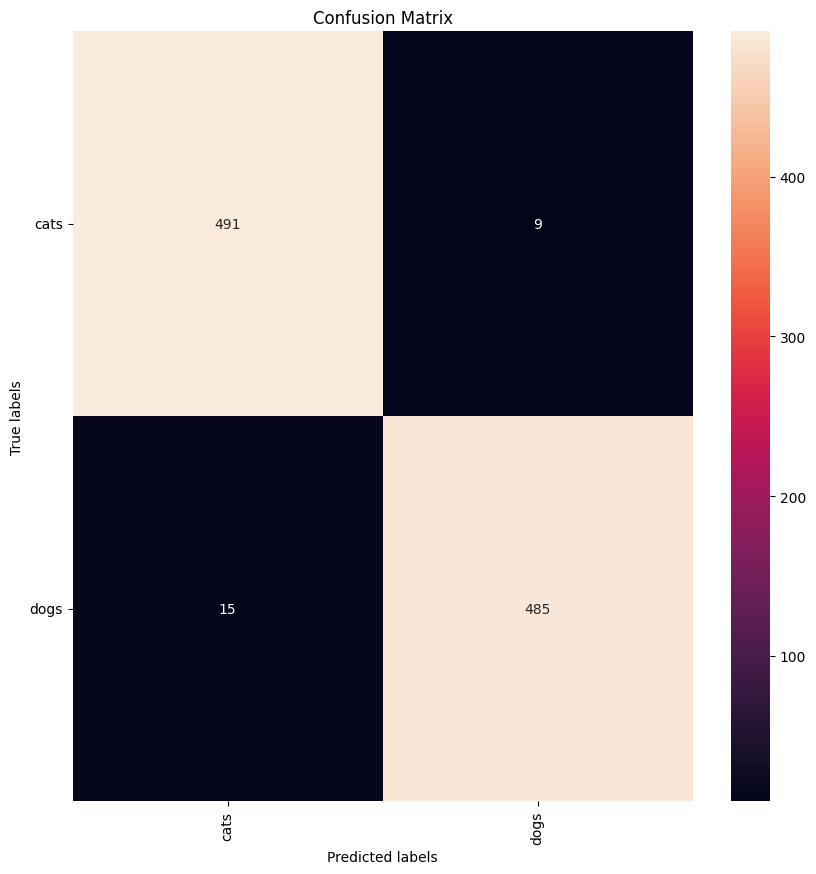

In [ ]:
trainer.run(train_loader, max_epochs=40)

/tmp/ipython-input-2459398557.py:2: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  sns.lineplot(training_history, palette=sns.palettes.dark_palette(color='green'))


<Axes: >

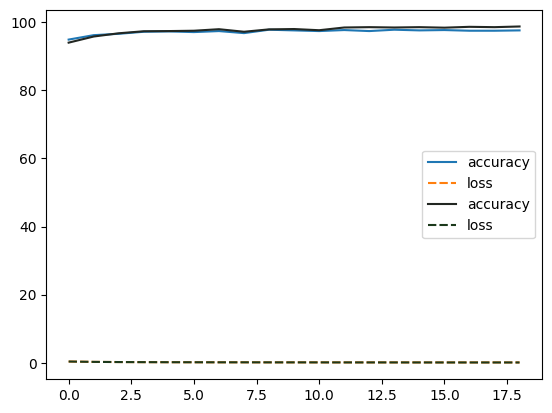

In [ ]:

sns.lineplot(val_history)
sns.lineplot(training_history, palette=sns.palettes.dark_palette(color='green'))

In [ ]:
def fetch_last_checkpoint_model_filename(model_save_path):
    import os
    checkpoint_files = os.listdir(model_save_path)
    checkpoint_files = [f for f in checkpoint_files if '.pt' in f]
    checkpoint_iter = [
        int(x.split('_')[2].split('.')[0])
        for x in checkpoint_files]
    last_idx = np.array(checkpoint_iter).argmax()
    return os.path.join(model_save_path, checkpoint_files[last_idx])

model.load_state_dict(torch.load(fetch_last_checkpoint_model_filename('/content/models')))
print("Модель загружена")

Модель загружена


In [ ]:
fi = files.upload()

path = fi.popitem()[0]

img=Image.open(path)
tr=T.Compose([T.Resize([224,224]),T.ToTensor()])
tensor=tr(img)
tensor = tensor.to(device)
tensor = tensor.unsqueeze_(0)

model.eval()
output=model(tensor)
print(F.softmax(output.to('cpu'), dim=1))

if (int(torch.argmax(F.softmax(output.to('cpu'), dim=1))) == 1):
    print('Собака')
else:
    print('Кот')

Saving photo_2025-07-04_05-02-30.jpg to photo_2025-07-04_05-02-30.jpg
tensor([[0.3903, 0.6097]], grad_fn=<SoftmaxBackward0>)
Собака
